In [29]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns


# MATPLOTLIB PARAMETERS
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 7
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 14
OVERALL_COLOR = "#565656"
NEUTRAL_COLOR = "#00a6e7"
A_COLOR = "#f78536"
B_COLOR = "#7ed3b2"
COLORS = [OVERALL_COLOR, A_COLOR, B_COLOR]

In [30]:
# HELPERS

def pct_style(df, columns):
    formatting = {c: "{:.2%}" for c in columns}
    return df.style.format(formatting)

def pct_abstract(serie, total, name=""):
    if name:
        serie.name = name
    pct = (serie/total)#l*100).round(1)
    abstract = serie.to_frame()
    abstract["%"] = pct
    abstract = pct_style(abstract, ["%"])
    return abstract


### 1. READ DATA

In [31]:
df = pd.read_csv("events_log.csv").set_index("uuid")
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y%m%d%H%M%S")
df["day"] = df["timestamp"].dt.floor("d")
df = df.sort_values(by=["session_id", "timestamp"])
df.head(10)

,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,day
uuid,,,,,,,,,
e6f9280c8df5536490eb925a91979a3b,2016-03-03 15:20:45,0000cbcb67c19c45,b,searchResultPage,NaN,fdeeb9aaf0130d41,20.0,NaN,2016-03-03
5b394c862bf657d98bcd25589a5247ac,2016-03-07 08:49:55,0001382e027b2ea4,b,searchResultPage,NaN,7aa28c36c03380a0,18.0,NaN,2016-03-07
cae3f7c7ce5d5d28b4bd6d318d962b1b,2016-03-07 08:49:58,0001382e027b2ea4,b,visitPage,NaN,f88793c95e778898,NaN,1.0,2016-03-07
f3e75c59c52251bb9b6585bb04284ee3,2016-03-07 08:50:08,0001382e027b2ea4,b,checkin,10.0,f88793c95e778898,NaN,1.0,2016-03-07
f01620582b615c03812cb1af2e804102,2016-03-07 08:50:18,0001382e027b2ea4,b,checkin,20.0,f88793c95e778898,NaN,1.0,2016-03-07
c6de195749b356d8ae2a03f06878fec1,2016-03-07 08:50:28,0001382e027b2ea4,b,checkin,30.0,f88793c95e778898,NaN,1.0,2016-03-07
dce8005fec955a1a9f3b2571d5f9866e,2016-03-07 08:50:38,0001382e027b2ea4,b,checkin,40.0,f88793c95e778898,NaN,1.0,2016-03-07
235b45f31d7e5afab38f4807b09a2880,2016-03-07 08:50:48,0001382e027b2ea4,b,checkin,50.0,f88793c95e778898,NaN,1.0,2016-03-07
fb0ae5ac2e505df28984feb1f6774172,2016-03-07 08:50:58,0001382e027b2ea4,b,checkin,60.0,f88793c95e778898,NaN,1.0,2016-03-07


In [32]:
records = len(df)
print("Number of events: ", records)

Number of events:  400165


### 2. CLEAN DATA

In [33]:
# Drop Visit Page longs without result position since are weird events that break checkin events.
df = df[~((df["action"] == "visitPage") & (df["result_position"].isna()))]

records = len(df)
print(f"Number of events: {records} after filtering.")

Number of events: 394137 after filtering.


In [34]:
# Drop sessions where the links visited are greater that the results of the search itself.
max_results_by_session = df.groupby("session_id")[["n_results", "result_position"]].max()
result_position_gt_n_results = max_results_by_session[max_results_by_session["result_position"] > max_results_by_session["n_results"]].index
df = df[~df["session_id"].isin(result_position_gt_n_results)]

print(f"Remove {len(result_position_gt_n_results)} sessions where the links visited are greater than the results of the search.")
records = len(df)
print(f"Number of events: {records} after filtering.")

Remove 99 sessions where the links visited are greater than the results of the search.
Number of events: 391247 after filtering.


In [35]:
# Only keep the last checkin continous event for every session since it summarizes the time spend on "checkin" status and reduce dataframe size a lot.

def detect_last_checkin(action, next_action, session_id, next_session_id):
    is_last_checkin = False
    if session_id == next_session_id:
        if (action == "checkin") & ( next_action != "checkin"):
            is_last_checkin = True
    else:
        if action == "checkin":
            is_last_checkin = True
            
    return is_last_checkin


last_checkin_row = []
past_row = df.iloc[1]
for index, row in tqdm(df.iloc[1:].iterrows(), total=len(df)):
    current_row = row
    last_checkin_row.append(detect_last_checkin(past_row['action'], current_row['action'], past_row['session_id'], current_row['session_id']))
    past_row = current_row
# HANDLE LAST ROW IS A CHECKIN ACTION 
last_checkin_row.append(True if current_row['action'] == "checkin" else False)

# FILTER
df["is_last_checkin"] = last_checkin_row
df = df[((df["is_last_checkin"] == True) | (df["action"] != "checkin"))]

records = len(df)
print(f"Number of events: {records} after filtering.")

  0%|          | 0/391247 [00:00<?, ?it/s]

Number of events: 197194 after filtering.


### 3. DATA ANALYSIS

first event: 2016-03-01 00:00:01
last even: 2016-03-08 20:24:32


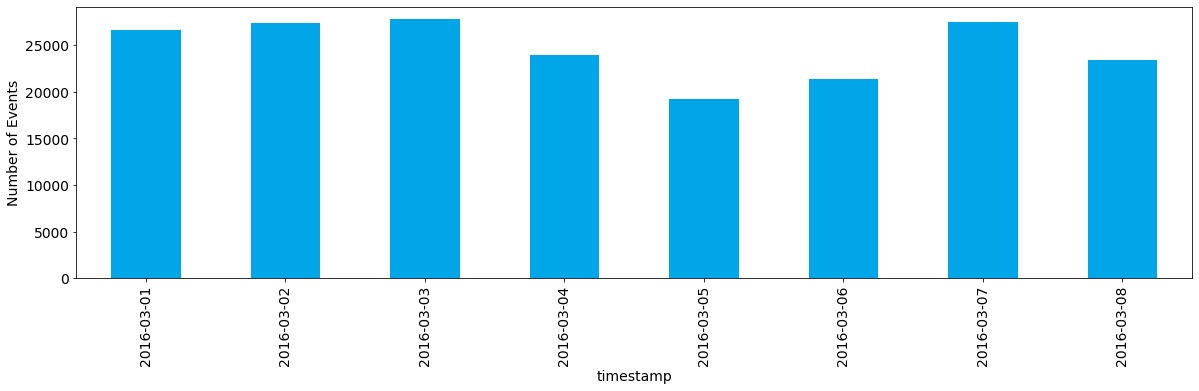

In [36]:
print("first event:", df["timestamp"].min())
print("last even:", df["timestamp"].max())

daily_events = df.groupby(df["timestamp"].dt.floor("d"))["timestamp"].count()
daily_events.index = daily_events.index.astype(str)
daily_events.plot(kind="bar", color=NEUTRAL_COLOR)
plt.ylabel("Number of Events")
plt.show()

In [37]:
display(pct_abstract(df.isna().sum(), records, name="NULLS"))

,NULLS,%
timestamp,0,0.00%
session_id,0,0.00%
group,0,0.00%
action,0,0.00%
checkin,168770,85.59%
page_id,0,0.00%
n_results,61996,31.44%
result_position,138154,70.06%
day,0,0.00%
is_last_checkin,0,0.00%


In [38]:
unique_sessions = df['session_id'].nunique()
unique_sessions_pct = round(unique_sessions/len(df)*100, 1)
print(f"distinct user sessions: {unique_sessions} ({unique_sessions_pct}%)")

unique_pages = df['page_id'].nunique()
unique_pages_pct = round(unique_sessions/len(df)*100, 1)
print(f"distinct page ids: {unique_pages} ({unique_pages_pct}%)")

display(pct_abstract(df["action"].value_counts(), records))
display(pct_abstract(df.groupby("session_id")["group"].first().value_counts(), unique_sessions))

distinct user sessions: 67927 (34.4%)
distinct page ids: 171735 (34.4%)


,action,%
searchResultPage,135198,68.56%
visitPage,33572,17.02%
checkin,28424,14.41%


,group,%
b,38593,56.82%
a,29334,43.18%


### 4. clickthrough rate (CTR)

In [39]:
def general_ctr(df):
    total_visited = (df["action"] == "visitPage").sum()
    total_searches = (df["action"] == "searchResultPage").sum()
    
    ctr = total_visited/total_searches
    return round(ctr, 4)

ctr_a = general_ctr(df[df["group"]=="a"])
ctr_b = general_ctr(df[df["group"]=="b"])
ctr_overall = general_ctr(df)

print(f"CTR group A: {ctr_a:.2%}")
print(f"CTR group B: {ctr_b:.2%}", )
print(f"CTR group OVERALL: {ctr_overall:.2%}")

CTR group A: 29.46%
CTR group B: 15.29%
CTR group OVERALL: 24.83%


,overall,a,b
day,,,
2016-03-01 00:00:00,24.26%,29.94%,12.05%
2016-03-02 00:00:00,24.27%,29.25%,12.77%
2016-03-03 00:00:00,24.89%,30.12%,13.27%
2016-03-04 00:00:00,25.48%,29.65%,16.96%
2016-03-05 00:00:00,25.09%,29.10%,17.60%
2016-03-06 00:00:00,25.63%,30.53%,16.66%
2016-03-07 00:00:00,24.69%,28.29%,17.49%
2016-03-08 00:00:00,24.65%,28.91%,16.11%


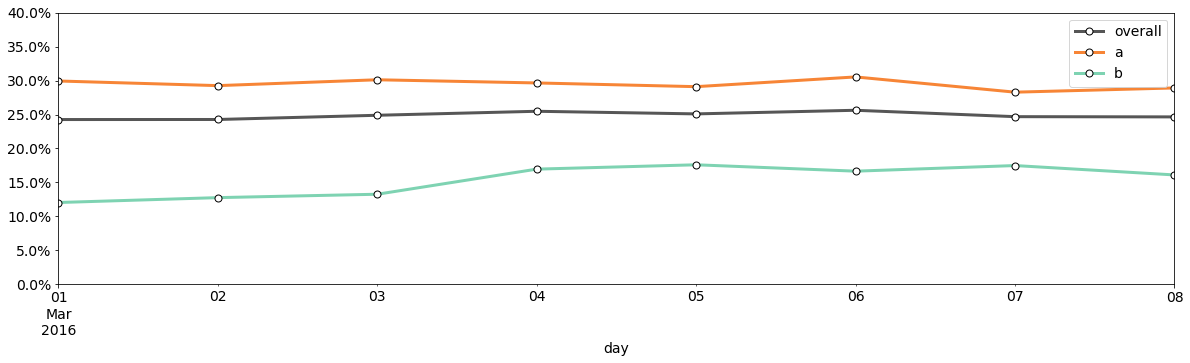

In [40]:
def daily_ctr(df):
    visited_daily = df[(df["action"] == "visitPage")].groupby("day")["action"].count()
    search_daily = df[(df["action"] == "searchResultPage")].groupby("day")["action"].count()
    ctr_rate_daily = (visited_daily/search_daily)
    return ctr_rate_daily

ctr_rate_daily = daily_ctr(df)
ctr_rate_daily_a = daily_ctr(df[df["group"]=="a"])
ctr_rate_daily_b = daily_ctr(df[df["group"]=="b"])

df_ctr = ctr_rate_daily.to_frame()
df_ctr.columns = ["overall"]
df_ctr["a"] = pd.DataFrame(ctr_rate_daily_a)
df_ctr["b"] = pd.DataFrame(ctr_rate_daily_b)

display(pct_style(df_ctr, df_ctr.columns))
ax = (df_ctr*100).plot(color=COLORS, marker="o", markeredgecolor="black",markerfacecolor="w")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylim((0, 40))
plt.show()

MEAN DAILY CTR


,mean daily CTR
overall,24.87%
a,29.47%
b,15.37%


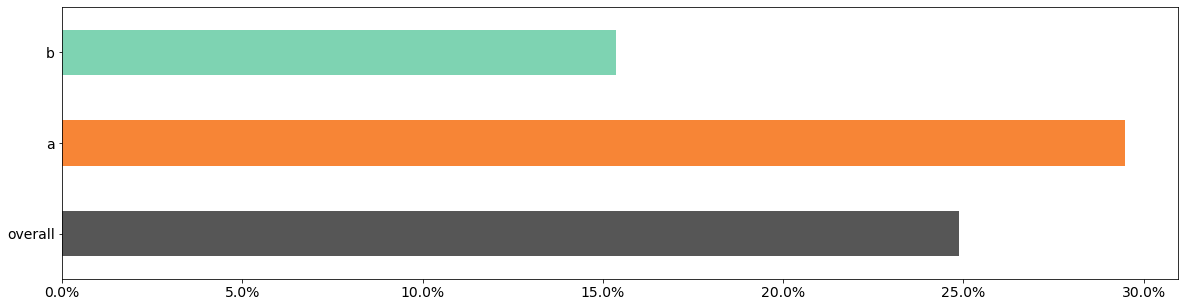

In [41]:
print("MEAN DAILY CTR")
df_ctr_mean = df_ctr.mean() 
df_ctr_mean.name = "mean daily CTR"
df_ctr_mean = df_ctr_mean.to_frame()
display(pct_style(df_ctr_mean, df_ctr_mean.columns))
ax = (df_ctr_mean["mean daily CTR"]*100).plot(kind="barh", color=COLORS, rot=0)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

### What is our daily overall clickthrough rate? 
The daily overall ctr is 24.87%, so more than 1 quarter of the users that search is actually accessing to the any result

### How does it vary between the groups?
The control group A is outperforming (+14% on average) the group B.


### 5. RESULT VISITED 

,result_position
1.0,0.671259
2.0,0.808304
3.0,0.877604
4.0,0.913887
5.0,0.935595
6.0,0.951573
7.0,0.961630
8.0,0.968120
9.0,0.973206
10.0,0.978026


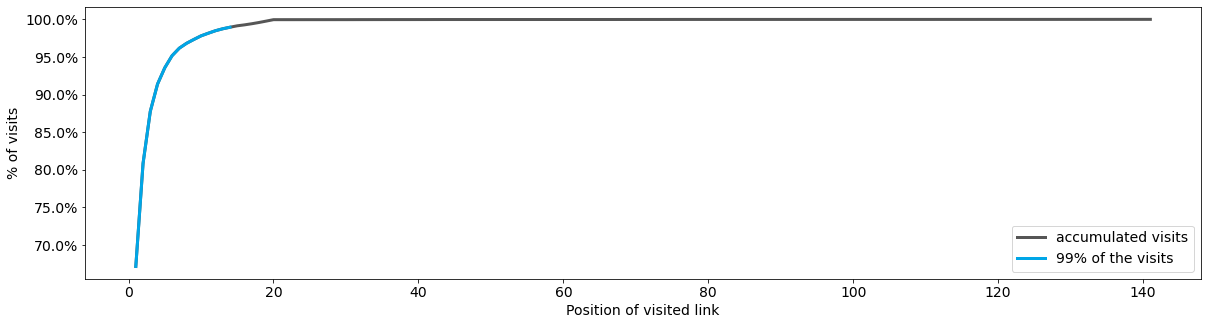

In [42]:
first_visited_page = df[df["action"] == "visitPage"].sort_values(by=["session_id", "timestamp"]).groupby("session_id").first()["result_position"]

# accumulated probability to visit link
first_visited_page_cumsum = (first_visited_page.value_counts()/ len(first_visited_page)).sort_index().cumsum()
display(first_visited_page_cumsum.to_frame())

# PLOT
(first_visited_page_cumsum*100).plot(color=OVERALL_COLOR)
ax = (first_visited_page_cumsum[first_visited_page_cumsum < 0.99]*100).plot(color=NEUTRAL_COLOR)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(["accumulated visits", "99% of the visits"])
plt.ylabel("% of visits")
plt.xlabel("Position of visited link")
plt.show()

In [43]:
first_visited_page = df[df["action"] == "visitPage"].sort_values(by=["session_id", "timestamp"]).groupby(["session_id", "day"]).first()["result_position"].reset_index(level=1)
first_visited_page.groupby("day").agg([pd.Series.mode, "median"])

result_position       
                      mode median
day                              
2016-03-01             1.0    1.0
2016-03-02             1.0    1.0
2016-03-03             1.0    1.0
2016-03-04             1.0    1.0
2016-03-05             1.0    1.0
2016-03-06             1.0    1.0
2016-03-07             1.0    1.0
2016-03-08             1.0    1.0

### Which results do people tend to try first? 
* 99% of the sessions are under the 15th link.
* 90% of the sessions which opens a link area under the 4th result. 
* The 1st result is the most visited (67% of the sessions) at the first try.

### How does it change day-to-day?
It does change between the days, the most common visited link (mode) at first try is the 1st link.

### 6. ZERO RESULTS RATE (ZRR)

In [44]:
df_searches = df[(df["action"] == "searchResultPage")]
df_zero_results = df_searches[(df_searches["n_results"] == 0)]
len(df_zero_results)/len(df_searches)

0.18551309930620274

,overall,a,b,diff_a_vs_b
day,,,,
2016-03-01 00:00:00,18.87%,18.84%,18.94%,-0.10%
2016-03-02 00:00:00,19.01%,19.14%,18.71%,0.43%
2016-03-03 00:00:00,18.10%,18.04%,18.24%,-0.19%
2016-03-04 00:00:00,18.39%,18.76%,17.62%,1.15%
2016-03-05 00:00:00,18.53%,17.87%,19.76%,-1.89%
2016-03-06 00:00:00,17.69%,16.99%,18.96%,-1.97%
2016-03-07 00:00:00,18.26%,18.33%,18.12%,0.21%
2016-03-08 00:00:00,19.48%,19.77%,18.89%,0.88%


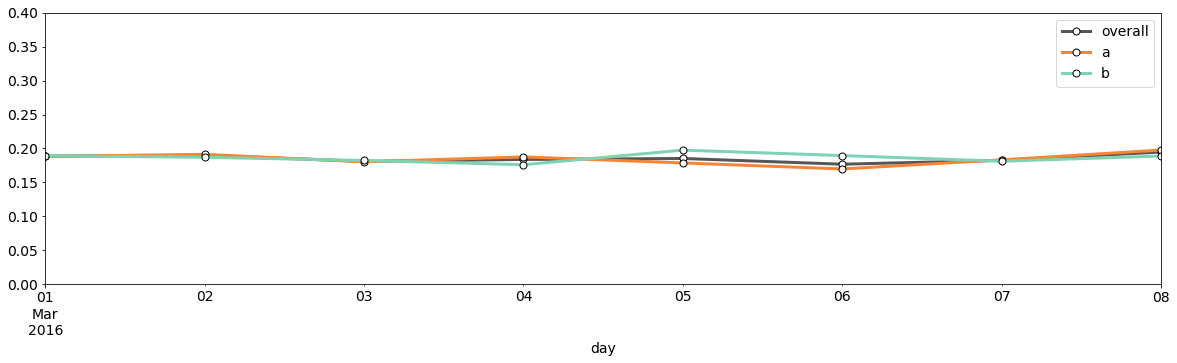

In [45]:
def daily_zrr(df):
    df_searches = df[(df["action"] == "searchResultPage")]
    zero_results_daily = df_searches[(df_searches["n_results"] == 0)].groupby("day")["action"].count()
    search_daily = df_searches.groupby("day")["action"].count()
    zrr_daily = (zero_results_daily/search_daily)
    return zrr_daily

zrr_daily = daily_zrr(df)
zrr_daily_a = daily_zrr(df[df["group"]=="a"])
zrr_daily_b = daily_zrr(df[df["group"]=="b"])

df_zrr = zrr_daily.to_frame()
df_zrr.columns = ["overall"]
df_zrr["a"] = pd.DataFrame(zrr_daily_a)
df_zrr["b"] = pd.DataFrame(zrr_daily_b)
df_zrr["diff_a_vs_b"] = df_zrr["a"] - df_zrr["b"]

display(pct_style(df_zrr, df_zrr.columns))
ax = df_zrr[["overall", "a", "b"]].plot(color=COLORS, marker="o", markeredgecolor="black",markerfacecolor="w")
plt.ylim((0, 0.4))
plt.show()

MEAN DAILY ZRR


,mean daily ZRR
overall,18.54%
a,18.47%
b,18.65%
diff_a_vs_b,-0.19%


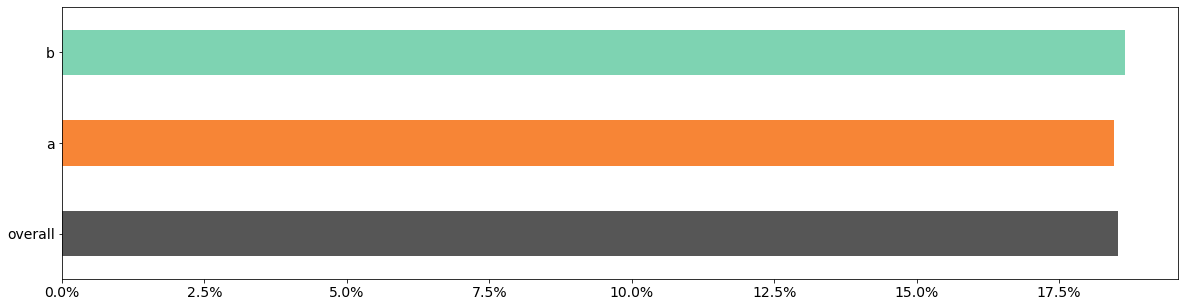

In [46]:
print("MEAN DAILY ZRR")
df_zrr_mean = df_zrr.mean() 
df_zrr_mean.name = "mean daily ZRR"
df_zrr_mean = df_zrr_mean.to_frame()
display(pct_style(df_zrr_mean, df_zrr_mean.columns))
ax = (df_zrr_mean["mean daily ZRR"].iloc[:3]*100).plot(kind="barh", color=COLORS, rot=0)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

### What is our daily overall zero results rate?
The mean daily overall ZRR is 18.54%.
### How does it vary between the groups?
Is prety similar for the 2 groups, meaning that our new feature is not affecting this metric. The diference between the two ZRR is very low (less than 1%) as well, suporting our conclusions.

### SESSION LENGHT vs USER GROUP

* QUESTION: is the length of your session affected by your group?

* NULL HYPOTHESIS: the session length is not affected by the user group.

* ALTERNATIVE HYPOTHESIS: the session length is affected by the user group.

In [47]:
grouper = df.groupby("session_id")
session_group_mapper = grouper["group"].first().to_dict()

session_length = grouper["timestamp"].agg([min, max])
session_length = (session_length["max"] - session_length["min"]).dt.seconds

session_length.name = "seconds"
session_length = session_length.to_frame()
session_length["group"] = session_length.index.map(session_group_mapper)

session_length.head(5)

,seconds,group
session_id,,
0000cbcb67c19c45,0,b
0001382e027b2ea4,303,b
0001e8bb90445cb2,435,b
000216cf18ae1ab1,58,a
000527f711d50dfc,0,b


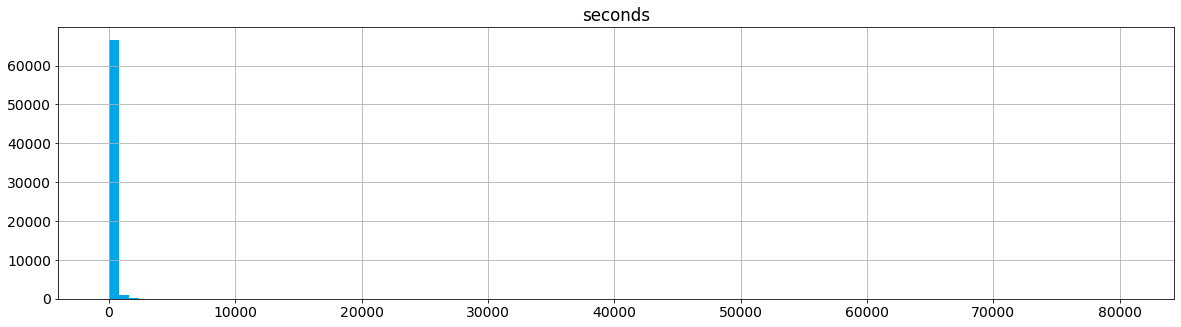

In [48]:
session_length.hist(bins=100, color=NEUTRAL_COLOR)
plt.show()


Postive skewed distribution with a very high presence of zeros. Let's group together the rare higher values (quantile 99%).


Sessions longer than 17.8 minutes are extremily rares


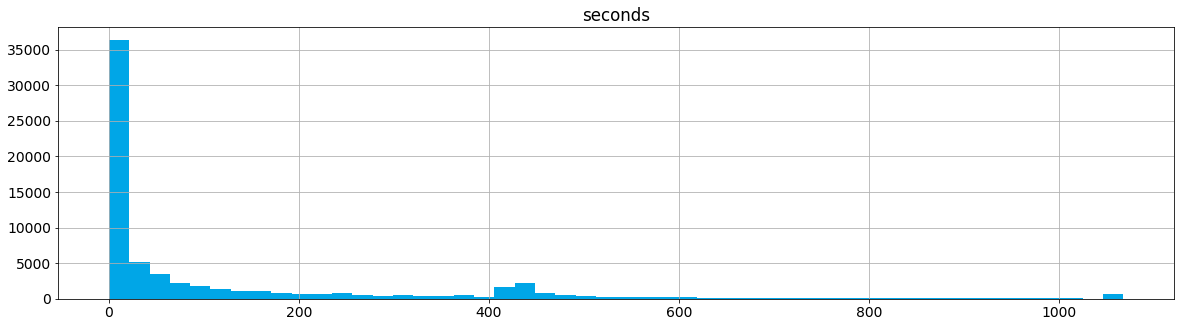

In [49]:
upper_threshold = session_length["seconds"].quantile(0.99)
print(f"Sessions longer than {upper_threshold/60} minutes are extremily rares")
session_length.loc[session_length["seconds"] > upper_threshold, "seconds"] = upper_threshold
session_length.hist(bins=50, color=NEUTRAL_COLOR)
plt.show()

group,a,b
count,29334.0,38593.0
mean,225.0,40.0
std,253.0,114.0
min,1.0,0.0
25%,33.0,0.0
50%,112.0,0.0
75%,405.0,7.0
max,1068.0,1068.0


Difference Mean Session Length: 185


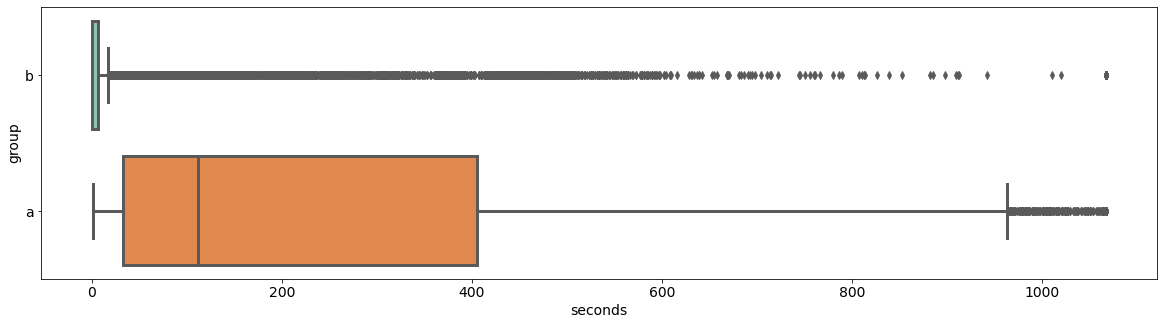

In [50]:
display(session_length.groupby("group")["seconds"].describe().T.round())
df_mean = session_length.groupby("group")["seconds"].mean()
print("Difference Mean Session Length:", round(df_mean["a"] - df_mean["b"]))
sns.boxplot(data=session_length, y="group", x="seconds",  palette=[B_COLOR, A_COLOR])
plt.show()

At this point is clear that session length is affected by the user group.

**On average, A users will spend 185 seconds more than a B user .**

Let's explore what happens with zero length sessions.

In [51]:
has_zero_length = (session_length[session_length["seconds"] == 0].value_counts().droplevel(0))
has_zero_length["a"] = 0
pct_abstract(has_zero_length,  session_length["group"].value_counts(), name="has_zero_length")

,has_zero_length,%
group,,
b,27617,71.56%
a,0,0.00%


**Is surprising that 72% of the group b sessions are only lasting zero seconds**, there are 2 possible scenarios:
* Bad Results: is posible that 72% of B users dislikes the results page and leave the session?
* Bug: on group B only first action is recorded so we lost track.

For the sake of the analysis, zero seconds sessions are ignored on the next steps.

group,a,b
count,29334.0,10976.0
mean,225.0,141.0
std,253.0,177.0
min,1.0,1.0
25%,33.0,14.0
50%,112.0,50.0
75%,405.0,234.0
max,1068.0,1068.0


Difference Mean Session Length: 84


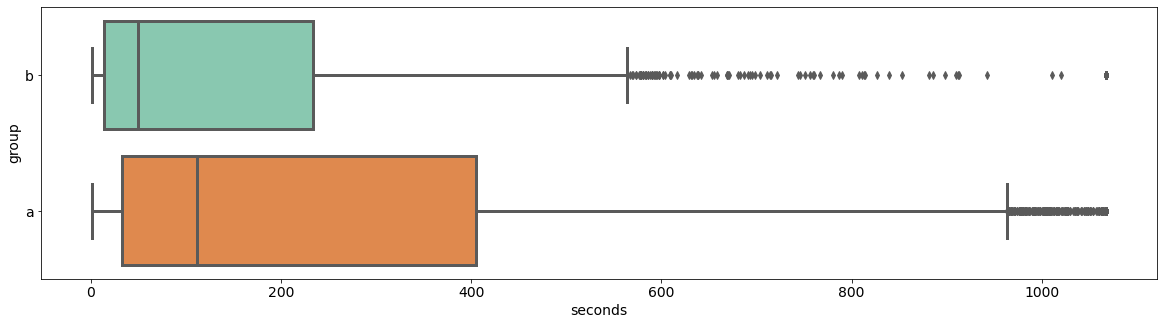

In [52]:
no_zero_session_length = session_length[session_length["seconds"] != 0]

display(no_zero_session_length.groupby("group")["seconds"].describe().T.round())
df_mean = no_zero_session_length.groupby("group")["seconds"].mean()
print("Difference Mean Session Length:", round(df_mean["a"] - df_mean["b"]))
sns.boxplot(data=no_zero_session_length, y="group", x="seconds", palette=[B_COLOR, A_COLOR])
plt.show()

Eventhough we remove zero sessions from group B, the session will be longer for A users.

**Removing zero seconds sessions, A users will spend 84 seconds more than a B user on average.**